In [316]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # For Mac
plt.rcParams['axes.unicode_minus'] = False  # This is to display minus signs correctly



In [317]:
df_demand = pd.read_csv('./data/demand_train.csv',  encoding="gbk")
df_demand['过账日期'] = pd.to_datetime(df_demand['过账日期'])

df_demand.head(10)

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
0,2018-01-06,0.33,2004,1000,5000,3002,4014
1,2018-01-08,0.09,2010,1000,5000,3002,4014
2,2018-01-09,0.09,2008,1000,5000,3002,4014
3,2018-01-10,0.10,2010,1000,5000,3002,4014
4,2018-01-11,0.17,2004,1000,5000,3002,4014
5,2018-01-13,0.06,2008,1000,5000,3002,4014
6,2018-01-15,0.45,2004,1000,5000,3002,4014
7,2018-01-18,0.03,2010,1000,5000,3002,4014
8,2018-01-19,0.06,2008,1000,5000,3002,4014
9,2018-01-20,0.84,2004,1000,5000,3002,4014


In [318]:
# 检查同日期+工厂+物料组合的重复
key_columns = ['过账日期', '工厂编码', '物料编码', '物料品牌', '物料类型', '物料品类']
date_factory_material_dups = df_demand[df_demand.duplicated(subset=key_columns, keep=False)]
df_demand = df_demand.groupby(key_columns)['需求量'].mean().reset_index()
date_factory_material_dups.head()

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
10,2018-01-22,0.06,2008,1000,5000,3002,4014
11,2018-01-22,0.06,2008,1000,5000,3002,4014
33,2018-04-06,0.23,2004,1000,5000,3002,4014
34,2018-04-06,0.20,2004,1000,5000,3002,4014
35,2018-04-09,0.80,2004,1000,5000,3002,4014


In [319]:
df_demand['年月'] = df_demand['过账日期'].dt.to_period('M').astype(str)
df_demand['月'] = df_demand['年月'].str[-2:]
df_demand['季度'] = df_demand['过账日期'].dt.quarter
df_demand.head()

,过账日期,工厂编码,物料编码,物料品牌,物料类型,物料品类,需求量,年月,月,季度
0,2018-01-01,2001,1029,5001,3002,4006,1.29,2018-01,01,1
1,2018-01-01,2001,1051,5001,3002,4013,0.09,2018-01,01,1
2,2018-01-01,2001,1054,5001,3002,4010,0.70,2018-01,01,1
3,2018-01-01,2001,1159,5001,3003,4001,1.24,2018-01,01,1
4,2018-01-01,2001,1167,5001,3003,4023,6.40,2018-01,01,1


In [320]:
df_demand.drop(['过账日期', '物料品牌', '物料类型', '物料品类'], axis=1, inplace=True)
df_demand.head()

,工厂编码,物料编码,需求量,年月,月,季度
0,2001,1029,1.29,2018-01,01,1
1,2001,1051,0.09,2018-01,01,1
2,2001,1054,0.70,2018-01,01,1
3,2001,1159,1.24,2018-01,01,1
4,2001,1167,6.40,2018-01,01,1


In [321]:
q_low = df_demand['需求量'].quantile(0.025)
q_high = df_demand['需求量'].quantile(0.975)

df_demand = df_demand[(df_demand['需求量'] >= q_low) & (df_demand['需求量'] <= q_high)]

In [322]:
# 经分析 需求量与库存量、物料编码、工厂编码有很大可能存在关联性，考虑到最终预测是通过工厂编码 + 物料编码 进行预测的，故这里将数据进行预处理

df_demand['工厂编码_物料编码'] = df_demand['工厂编码'].astype(str) + '_' + df_demand['物料编码'].astype(str)
df_demand['年'] = df_demand['年月'].str[:4]
df_final = df_demand.groupby(['工厂编码_物料编码', '年月', '年', '月', '季度']).agg({'需求量': 'sum' }).reset_index()
df_final['年'] = df_final['年'].astype(int)
df_final['月'] = df_final['月'].astype(int)
df_final['季度'] = df_final['季度'].astype(int)
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量
0,2000_1001,2018-01,2018,1,1,12.53
1,2000_1001,2018-02,2018,2,1,16.08
2,2000_1001,2018-03,2018,3,1,3.12
3,2000_1001,2018-04,2018,4,2,8.78
4,2000_1001,2018-05,2018,5,2,3.14


In [323]:
def create_features(df, group_col='工厂编码_物料编码', target_col='需求量'):
    """
    创建滑动和滞后特征
    """
    # 按组排序
    df = df.sort_values([group_col, '年', '月'])
    
    # 创建滞后特征
    for lag in [1, 2, 3, 4, 5]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    
    # 创建基于滞后特征的滑动窗口特征
    for window in [2, 3, 4]:
        df[f's_l_roll_{window}_mean'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).mean())
        df[f's_l_roll_{window}_max'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).max())
        df[f's_l_roll_{window}_min'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).min())
        df[f's_l_roll_{window}_std'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).std())
        df[f's_l_roll_{window}_median'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).median())
    
    return df

In [324]:

df_final = create_features(df_final)

df_final.head()
    

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
0,2000_1001,2018-01,2018,1,1,12.53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000_1001,2018-02,2018,2,1,16.08,12.53,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000_1001,2018-03,2018,3,1,3.12,16.08,12.53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000_1001,2018-04,2018,4,2,8.78,3.12,16.08,12.53,NaN,...,10.58,16.08,3.12,6.69,12.53,NaN,NaN,NaN,NaN,NaN
4,2000_1001,2018-05,2018,5,2,3.14,8.78,3.12,16.08,12.53,...,9.33,16.08,3.12,6.49,8.78,10.13,16.08,3.12,5.54,10.66


In [325]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['工厂编码_物料编码'] = le.fit_transform(df_final['工厂编码_物料编码'])
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
0,0,2018-01,2018,1,1,12.53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2018-02,2018,2,1,16.08,12.53,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2018-03,2018,3,1,3.12,16.08,12.53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2018-04,2018,4,2,8.78,3.12,16.08,12.53,NaN,...,10.58,16.08,3.12,6.69,12.53,NaN,NaN,NaN,NaN,NaN
4,0,2018-05,2018,5,2,3.14,8.78,3.12,16.08,12.53,...,9.33,16.08,3.12,6.49,8.78,10.13,16.08,3.12,5.54,10.66


In [326]:


# 划分训练集和测试集
df_train = df_final[df_final['年月'] < '2020-09']
df_test = df_final[df_final['年月'] >= '2020-09']
df_test.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median
30,0,2020-09,2020,9,3,1.80,6.00,13.20,3.97,10.87,...,7.72,13.20,3.97,4.85,6.00,8.51,13.20,3.97,4.26,8.44
31,0,2020-10,2020,10,4,4.80,1.80,6.00,13.20,3.97,...,7.00,13.20,1.80,5.77,6.00,6.24,13.20,1.80,4.95,4.98
32,0,2020-11,2020,11,4,8.40,4.80,1.80,6.00,13.20,...,4.20,6.00,1.80,2.16,4.80,6.45,13.20,1.80,4.83,5.40
65,1,2020-09,2020,9,3,39.56,13.72,49.29,48.32,59.67,...,37.11,49.29,13.72,20.26,48.32,42.75,59.67,13.72,20.02,48.80
66,1,2020-10,2020,10,4,73.01,39.56,13.72,49.29,48.32,...,34.19,49.29,13.72,18.38,39.56,37.72,49.29,13.72,16.59,43.94


In [327]:
#  训练模型
features = [col for col in df_final.columns if col not in ['工厂编码_物料编码', '年月', '需求量']]
target = '需求量'

print(features)
X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]


['年', '月', '季度', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 's_l_roll_2_mean', 's_l_roll_2_max', 's_l_roll_2_min', 's_l_roll_2_std', 's_l_roll_2_median', 's_l_roll_3_mean', 's_l_roll_3_max', 's_l_roll_3_min', 's_l_roll_3_std', 's_l_roll_3_median', 's_l_roll_4_mean', 's_l_roll_4_max', 's_l_roll_4_min', 's_l_roll_4_std', 's_l_roll_4_median']


In [328]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    boosting_type='goss',
    random_state=42
)
eval_result = {}  # 用于保存评估结果


model.fit(
    X_train,
    y_train, 
    eval_set=[(X_test, y_test)],  # 监控训练集误差
    eval_metric='l2',  # 使用MSE（L2损失）
    callbacks=[lgb.record_evaluation(eval_result)],  # 记录评估结果
    )

# 提取训练误差数据
# train_error = eval_result['valid_0']['l2']

# # 绘制训练误差曲线
# plt.figure(figsize=(10, 6))
# plt.plot(train_error, label='Training Error (MSE)')
# plt.title('Training Error vs. Boosting Iterations')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Mean Squared Error')
# plt.legend()
# plt.grid(True)
# plt.show()

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5122
[LightGBM] [Info] Number of data points in the train set: 13470, number of used features: 23
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score

LGBMRegressor(boosting_type='goss', colsample_bytree=0.8, learning_rate=0.05,
              n_estimators=500, objective='regression', random_state=42,
              subsample=0.8)

In [329]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 对测试集进行预测
y_test_pred = model.predict(df_test[features])

# 2. 计算评估指标
mse = mean_squared_error(df_test[target], y_test_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(df_test[target], y_test_pred)
r2 = r2_score(df_test[target], y_test_pred)


# 打印结果
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
MSE: 160.9195
MAE: 7.9621


In [330]:
df_predict_lgb = df_test.copy()
df_predict_lgb['预测值'] = y_test_pred  # 添加预测值列

# 2. 计算绝对差异和相对差异
df_predict_lgb['绝对差异'] = df_predict_lgb['预测值'] - df_predict_lgb['需求量']
df_predict_lgb['相对差异(%)'] = (df_predict_lgb['绝对差异'] / df_predict_lgb['需求量']).abs() * 100


df_predict_lgb.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_3_std,s_l_roll_3_median,s_l_roll_4_mean,s_l_roll_4_max,s_l_roll_4_min,s_l_roll_4_std,s_l_roll_4_median,预测值,绝对差异,相对差异(%)
30,0,2020-09,2020,9,3,1.80,6.00,13.20,3.97,10.87,...,4.85,6.00,8.51,13.20,3.97,4.26,8.44,4.91,3.11,172.87
31,0,2020-10,2020,10,4,4.80,1.80,6.00,13.20,3.97,...,5.77,6.00,6.24,13.20,1.80,4.95,4.98,6.29,1.49,30.94
32,0,2020-11,2020,11,4,8.40,4.80,1.80,6.00,13.20,...,2.16,4.80,6.45,13.20,1.80,4.83,5.40,5.32,-3.08,36.69
65,1,2020-09,2020,9,3,39.56,13.72,49.29,48.32,59.67,...,20.26,48.32,42.75,59.67,13.72,20.02,48.80,6.19,-33.37,84.35
66,1,2020-10,2020,10,4,73.01,39.56,13.72,49.29,48.32,...,18.38,39.56,37.72,49.29,13.72,16.59,43.94,37.68,-35.33,48.39


In [331]:
# 3. 按绝对差异排序（可选）
df_compare_lgb = df_predict_lgb.sort_values(by='相对差异(%)', key=abs, ascending=False)

# 4. 显示关键列（按需调整显示的列）
columns_to_show = ['工厂编码_物料编码', '年月', '需求量', '预测值', '绝对差异', '相对差异(%)']
df_compare_lgb = df_compare_lgb[columns_to_show]

# 5. 格式化输出（保留两位小数）
pd.options.display.float_format = '{:.2f}'.format
print("预测值与真实值对比表：")
df_compare_lgb.head(10)  # 显示差异最大的前10条样本

预测值与真实值对比表：


,工厂编码_物料编码,年月,需求量,预测值,绝对差异,相对差异(%)
7102,476,2020-09,0.08,3.04,2.96,3698.70
3787,223,2020-10,1.00,37.80,36.80,3679.80
4699,287,2020-11,0.28,8.39,8.11,2895.70
7040,460,2020-09,0.40,10.74,10.34,2584.48
13362,863,2020-09,1.00,19.42,18.42,1842.36
6999,454,2020-09,1.25,16.60,15.35,1228.01
4961,315,2020-11,0.80,10.58,9.78,1222.49
3754,219,2020-09,1.00,12.95,11.95,1195.31
2051,109,2020-11,0.08,0.92,0.84,1044.89
4473,268,2020-09,0.40,4.35,3.95,987.12


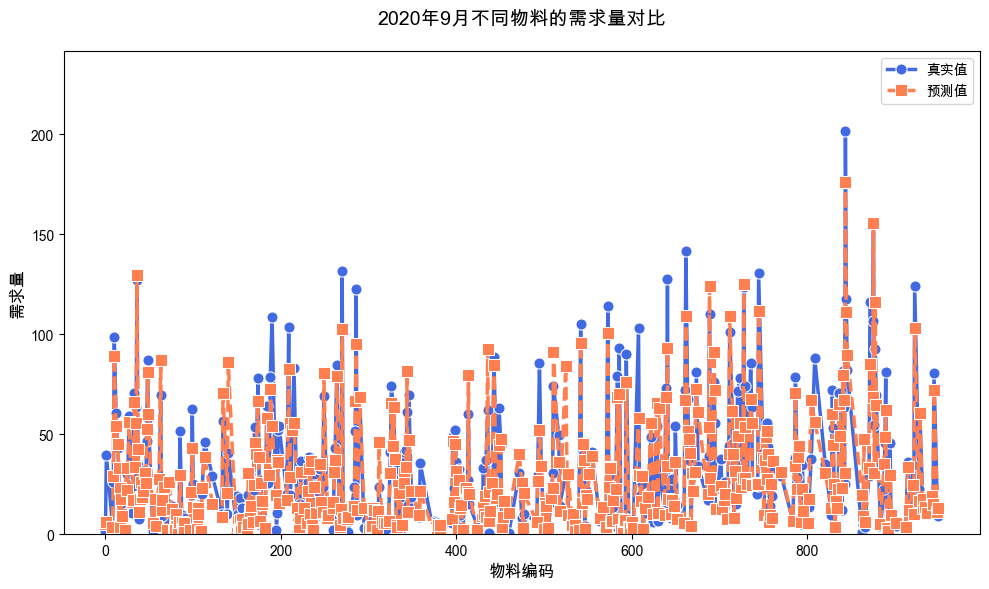

In [332]:
df_test_lgb_9 = df_predict_lgb[df_test['年月'] == '2020-09']
plt.figure(figsize=(10, 6))

# 绘制折线图（带标记点）
lineplot = sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='需求量',
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='royalblue',
    label='真实值'
)
sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='预测值',
    marker='s',
    markersize=8,
    linewidth=2.5,
    color='coral',
    linestyle='--',
    label='预测值'
)

plt.title('2020年9月不同物料的需求量对比', fontsize=14, pad=20)
plt.xlabel('物料编码', fontsize=12)
plt.ylabel('需求量', fontsize=12)

# 调整Y轴范围（考虑数值差异大的情况）
plt.ylim(0, df_test_lgb_9['需求量'].max() * 1.2)

# 显示图表
plt.tight_layout()
plt.show()